# Imports

In [2]:
# Machine Learning
from sklearn.cluster import DBSCAN

# Data library
import pandas as pd
import numpy as np

# Visualizing
import matplotlib.pyplot as plt

# Converting
import json

# Utility
import random
import os

# BigQuery

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
credentials = service_account.Credentials.from_service_account_file('./dataset/safe-route-351803-701f86f6b63e.json')

project_id = 'safe-route-351803'
bqclient = bigquery.Client(credentials= credentials,project=project_id)

In [ ]:
query_job = bqclient.query("""
   SELECT *
   FROM jakarta_crime_history.table_crime_dummy
   LIMIT 2500""")

results = query_job.to_dataframe() # Wait for the job to complete.

# Constants

In [3]:
# DBScan parameters
EPSILON = 200 # meter
MIN_POINTS = 3 # minimum locations/points for core

# Unit conversion
ANGLE_TO_METER_RATIO = 0.00001 / 1.11 # source : https://www.usna.edu/Users/oceano/pguth/md_help/html/approx_equivalents.htm

# Files
dataset_file = "./dataset/crime_history.csv"
model_file = "./model/clustering.json"
statistic_file = "./model/area_statistic.json"

# Folder
geojson_folder = "./dataset/geoJSON/"

# Misc
geojson_extension = ".geojson"

# Data

In [6]:
# Open dataset
data = pd.read_csv(dataset_file)

# Drop NaN value
data = data.dropna()

# Copy data before dropped
raw_data = data.copy()

# Drop unused columns
data = raw_data.drop(labels=['id', 'date', 'time', 'type', 'districts', 'subdistrict'], axis=1)

# Data preview
data.head()

,latitude,longitude
0,-6.169094,106.875481
1,-6.169097,106.875371
2,-6.169124,106.875662
3,-6.169101,106.874989
4,-6.169096,106.874768


# Utils

## Unit Conversion

In [7]:
def meter_to_angle(meter):
    """Convert meter to angle"""
    return meter * ANGLE_TO_METER_RATIO

def angle_to_meter(angle):
    """Convvert angle to meter"""
    return angle / ANGLE_TO_METER_RATIO

# Model

## Initialize

In [8]:
def create_model() -> DBSCAN:
    """Creating DBSCAN model"""
    dbscan = DBSCAN(eps=meter_to_angle(EPSILON), min_samples=MIN_POINTS)
    dbscan = dbscan.fit(data)
    
    return dbscan

In [9]:
model = create_model()

## "Centroids"

In [10]:
def model_centroids(model):
    """Return the "centroids" of the model"""
    # Obtaining labels
    labels = model.labels_
    unique_labels = set(labels)
    # Generate colors
    colors = [tuple(plt.cm.Spectral(each)) for each in np.linspace(0, 1, len(unique_labels))]
    # Shuffle colors
    random.shuffle(colors)
    
    # Calculate centroids
    return_data = {'centroids': []}
    for label in unique_labels:
        if label == -1:
            # Skip noise
            continue
        # Calculate centroids coordinate and range
        label_points = data[labels==label]
        centroid = np.mean(label_points, axis=0)
        # Max distance from centroid to cluster member
        max_distance = np.sqrt(np.sum(np.square(label_points - centroid), axis=1)).to_numpy().flatten().max()
        avg_point = np.mean(label_points, axis=0)
        
        # Calculate crime info for each centroids
        crime_info = raw_data[labels==label].groupby('type').size().to_dict()
        
        # Generating data
        return_data['centroids'].append({
            'id': int(label),
            'latitude': float(avg_point['latitude']),
            'longitude': float(avg_point['longitude']),
            'range': float(angle_to_meter(max_distance)),
            'crime_info': crime_info
        })
    
    return return_data
    
centroids = model_centroids(model)

## Visualizing

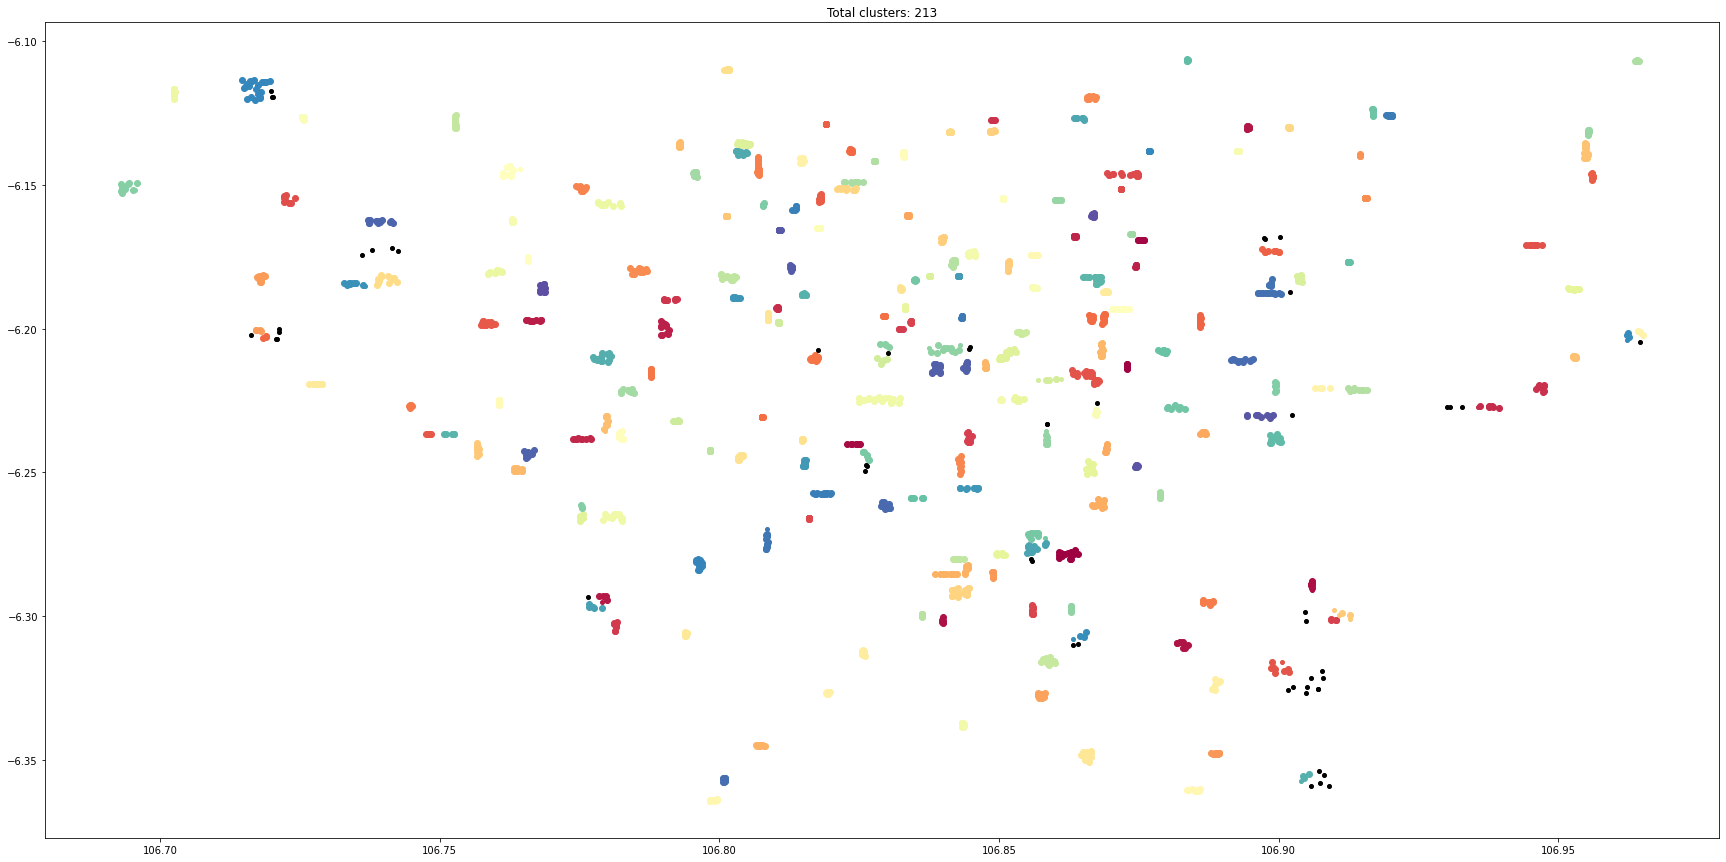

In [11]:
# Visualizing source: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

def visualize_model(model):
    """Visualize the model to a 2d plane"""
    # Figure size configuration
    plt.figure(figsize=(30,15))
    
    # Obtaining labels
    labels = model.labels_
    unique_labels = set(labels)
    
    # Number of clusters
    clusters = len(unique_labels)
    if -1 in unique_labels:
        clusters -= 1
    
    # Generate color
    colors = [tuple(plt.cm.Spectral(each)) for each in np.linspace(0, 1, len(unique_labels))]
    # Shuffle colors
    random.shuffle(colors)
    # Default noise color
    noise_color = (0.0, 0.0, 0.0, 1.0)

    # Creating color mask
    color_mask = np.zeros_like(labels, dtype=bool)
    color_mask[model.core_sample_indices_] = True
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = noise_color
        else:
            col = colors[k]
        
        # Creating class mask
        class_mask = k == labels
        
        # Plotting core
        core_coordinate = data[class_mask & color_mask].to_numpy()
        plt.plot(
            core_coordinate[:, 1],
            core_coordinate[:, 0],
            'o',
            markerfacecolor=col,
            markeredgecolor=col,
            markersize=6,
        )

        # Plotting border
        border_coordinate = data[class_mask & ~color_mask].to_numpy()
        plt.plot(
            border_coordinate[:, 1],
            border_coordinate[:, 0],
            'o',
            markerfacecolor=col,
            markeredgecolor=col,
            markersize=4,
        )

    # Showing plot
    plt.title("Total clusters: %d" % clusters)
    plt.show()

visualize_model(model)

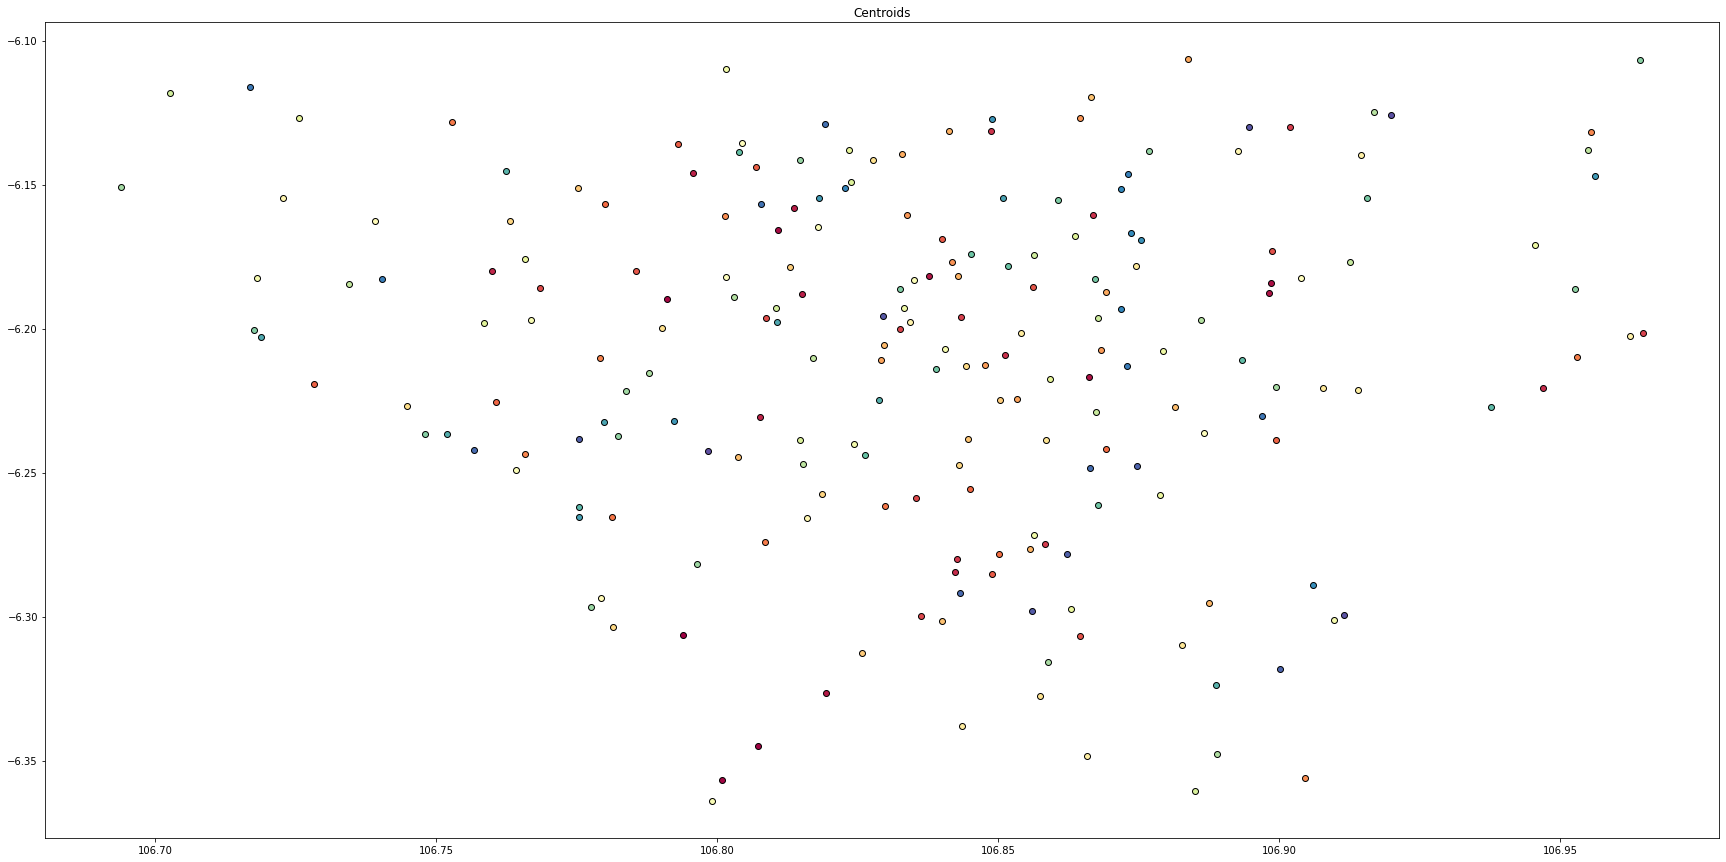

In [12]:
def visualize_centroids(centroids):
    """Visualize the model to a 2d plane"""
    # Figure size configuration
    plt.figure(figsize=(30,15))
    
    # Obtaining labels
    labels = model.labels_
    unique_labels = set(labels)
    
    # Generate color
    colors = [tuple(plt.cm.Spectral(each)) for each in np.linspace(0, 1, len(unique_labels))]
    # Shuffle colors
    random.shuffle(colors)

    # Plotting
    for centroid, col in zip(centroids['centroids'], colors):
        plt.plot(
            centroid['longitude'],
            centroid['latitude'],
            'o',
            markerfacecolor=col,
            markeredgecolor=[0,0,0,1],
            markersize=6,
        )

    # Showing plot
    plt.title("Centroids")
    plt.show()

visualize_centroids(centroids)

In [13]:
centroids

{'centroids': [{'id': 0,
   'latitude': -6.169105881499999,
   'longitude': 106.87538751666666,
   'range': 68.80840159470647,
   'crime_info': {'Assault / Battery': 3,
    'Attempt': 1,
    'Child Pornography': 1,
    'Harassment': 1,
    'Kidnapping': 1,
    'Manslaughter: Voluntary': 1,
    'Stalking': 1,
    'Statutory Rape': 2,
    'Theft': 1}},
  {'id': 1,
   'latitude': -6.1781329789,
   'longitude': 106.87448551,
   'range': 41.702981371917694,
   'crime_info': {'Aggravated Assault': 2,
    'Attempt': 1,
    'Embezzlement': 1,
    'Kidnapping': 1,
    'Manslaughter: Voluntary': 1,
    'Public Intoxication': 1,
    'Robbery': 1,
    'Statutory Rape': 2}},
  {'id': 2,
   'latitude': -6.182835121181816,
   'longitude': 106.86720832272727,
   'range': 263.6106332401204,
   'crime_info': {'Aggravated Assault': 1,
    'Aiding and Abetting / Accessory': 1,
    'Assault / Battery': 1,
    'Harassment': 1,
    'Manslaughter: Voluntary': 3,
    'Medical Marijuana': 1,
    'Murder: Second

# Area statistic

In [18]:
def coordinate_to_object(coordinate:tuple[float,float], swap:bool=False) -> dict[str,float]:
    """Convert coordinate in the form of tuple to object with latitude and longitude
    default mode require first element in the tuple to be latitude"""
    if swap:
        return {"latitude":coordinate[1], "longitude":coordinate[0]}
    else:
        return {"latitude":coordinate[0], "longitude":coordinate[1]}

def parse_geo_json(file_path):
    """Parse GEO JSON data to a dictionary with the following:
    Key: subdistrict name (string)
    Value: multi-polygon (list of float)"""
    geo_json_coordinates = {}
    for root, dirs, files in os.walk(file_path):
        # Iterate through all folder
        for filename in files:
            # Iterate all file
            if filename.endswith(geojson_extension):
                # Check file extension
                with open(os.path.join(root, filename)) as geo_json:
                    area_data = json.load(geo_json)
                    for sub_area_data in area_data["features"]:
                        flatten_list = list(np.array(sub_area_data["geometry"]["coordinates"], object).flatten())
                        geo_json_coordinates[sub_area_data["properties"]["name"]] = \
                            [coordinate_to_object((flatten_list[i], flatten_list[i+1]), True) for i in range(0,len(flatten_list),2)]
    return geo_json_coordinates

parse_geo_json(geojson_folder)

{'Cengkareng': [{'latitude': -6.178593, 'longitude': 106.7037},
  {'latitude': -6.1775944, 'longitude': 106.7054822},
  {'latitude': -6.1767991, 'longitude': 106.7069016},
  {'latitude': -6.1756454, 'longitude': 106.7068404},
  {'latitude': -6.1742231, 'longitude': 106.7068663},
  {'latitude': -6.1742741, 'longitude': 106.7086229},
  {'latitude': -6.174304, 'longitude': 106.7096498},
  {'latitude': -6.1743623, 'longitude': 106.7101903},
  {'latitude': -6.1743763, 'longitude': 106.710661},
  {'latitude': -6.173804, 'longitude': 106.7107058},
  {'latitude': -6.1734027, 'longitude': 106.7107814},
  {'latitude': -6.173249, 'longitude': 106.710817},
  {'latitude': -6.172591, 'longitude': 106.711205},
  {'latitude': -6.171818, 'longitude': 106.711809},
  {'latitude': -6.1716327, 'longitude': 106.7124952},
  {'latitude': -6.1704702, 'longitude': 106.7129158},
  {'latitude': -6.1689085, 'longitude': 106.7134725},
  {'latitude': -6.168535, 'longitude': 106.713613},
  {'latitude': -6.1683006, 'l

In [19]:
def generate_area_statistic(data, area_type='subdistrict'):
    """Generate data based on area_type (default is subdistrict)"""
    # Grouping data based on subdistrict and type
    statistic_data = data.copy()
    subdistrict_crime_statistic = statistic_data.groupby([area_type,'type']).size().to_dict()

    # Transform dictionary based on subdistrict
    subdisctrict_data = {}
    for key in subdistrict_crime_statistic:
        if subdisctrict_data.get(key[0]) is None:
            # Generate dictionary if it does not exist
            subdisctrict_data[key[0]] = {}
        subdisctrict_data[key[0]][key[1]] = subdistrict_crime_statistic[key]
    subdisctrict_data
    
    # Generte geo json coordinates data
    geo_json_data = parse_geo_json(geojson_folder)
    
    # Transform dictionary to json format
    statistic = {'statistic':[]}
    for subdistrict in subdisctrict_data:
        subdistrict_name = subdistrict.replace('_',' ')
        statistic['statistic'].append({
            'subdistrict': subdistrict_name,
            'total_crime': sum(subdisctrict_data[subdistrict].values()),
            'crime_info': subdisctrict_data[subdistrict],
            'coordinates': geo_json_data[subdistrict_name]
        })
        
    return statistic

statistic = generate_area_statistic(raw_data)

# Converting to JSON

In [20]:
# Saving model using json
with open(model_file, 'w') as f:
    json.dump(centroids, f, indent=2)

In [21]:
# Saving area statistic using json
with open(statistic_file, 'w') as f:
    json.dump(statistic, f, indent=2)